# Titanic rnd forest

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, cross_val_score, cross_val_predict ,GridSearchCV
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score

sns.set()

# This checks if the notebook is executed on Kaggle or on your local machine and
# acts accordingly with filenames.
fname_train = "train.csv"
fname_test = "test.csv"

try:
    os.environ['KAGGLE_DATA_PROXY_TOKEN']
except KeyError:
    pass
else:
    dirname = "/kaggle/input/titanic/"
    fname_train = dirname + fname_train
    fname_test = dirname + fname_test

In [2]:
titanic = pd.read_csv(fname_train)
titanic.Age.fillna(titanic.Age.mean(), inplace=True)

# Pretend we already know for sure that these are unimportant:
unnecessary = ["PassengerId", "Name","SibSp","Parch","Ticket", "Cabin", "Embarked"]
#unnecessary = ["PassengerId", "Name","Ticket", "Embarked"]
unnecessary = ["PassengerId", "Name","Ticket", "Embarked", "Cabin"]

titanic.drop(unnecessary, inplace=True, axis=1)
titanic

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.000000,1,0,7.2500
1,1,1,female,38.000000,1,0,71.2833
2,1,3,female,26.000000,0,0,7.9250
3,1,1,female,35.000000,1,0,53.1000
4,0,3,male,35.000000,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000
887,1,1,female,19.000000,0,0,30.0000
888,0,3,female,29.699118,1,2,23.4500
889,1,1,male,26.000000,0,0,30.0000


In [3]:
class CabinLetterOnly(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        df = pd.DataFrame(X, index=titanic.index, columns=titanic.columns)
        s_cabin_letters = df.Cabin.str.extract("^([A-Z]).*", expand = False)
        return np.c_[df.to_numpy(), s_cabin_letters]

sex_pip = Pipeline([
    ('one_hot', OneHotEncoder(categories=[titanic.Sex]))
])

fare_pip = Pipeline([
    ("fare_mean", SimpleImputer(strategy="mean")),
    ('fare_std', StandardScaler())
])

pclass_pip = Pipeline([
    ('pclass_std', StandardScaler())
])

age_pip = Pipeline([
    ('age_std', StandardScaler())
])

parch_pip = Pipeline([
    ('parch_std', StandardScaler())
])

sibsp_pip = Pipeline([
    ('sibsp_std', StandardScaler())
])

add_attrs = Pipeline([
    ("cabin_fill", SimpleImputer(strategy="most_frequent")),
    ("add_cabin_letters", CabinLetterOnly())
])

# new = add_attrs.fit_transform(titanic.values)
# titanic = pd.DataFrame(new, index=titanic.index, columns=titanic.columns.union(pd.Index(["Cabin_letter"]), sort=False))
# titanic.drop(["Cabin"], axis=1, inplace=True)

# cabin_pip = Pipeline([
#     ('cabin_1hot', OneHotEncoder(categories=[titanic.Cabin_letter]))
# ])

attr_pip = ColumnTransformer([
    #("passthrough", "passthrough", ["Pclass"]),
    ("pclass", pclass_pip, ["Pclass"]),
    ("sex", sex_pip, ["Sex"]),
    ("fare", fare_pip, ["Fare"]),
    ("age", fare_pip, ["Age"]),
    ("parch", parch_pip, ["Parch"]),
    ("sibsp", sibsp_pip, ["SibSp"]),
    #("cabin_add", add_attrs, ["Cabin"]),
    #("cabin_trans", cabin_pip, ["Cabin_letter"]),
], remainder="drop")


### models ###

log_reg_pip = Pipeline([
    ("attr_pip", attr_pip),
    ('log_reg', LogisticRegression(multi_class="multinomial"))
])

In [4]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_ix, test_ix in split.split(titanic, titanic["Sex"]):
    strat_train = titanic.loc[train_ix]
    strat_devtest = titanic.loc[test_ix]

In [5]:
titanic_labels = titanic["Survived"].astype(int)
strat_train_labels = strat_train["Survived"].astype(int)
strat_devtest_labels = strat_devtest["Survived"].astype(int)
strat_train.drop("Survived", inplace=True, axis=1)
strat_devtest.drop("Survived", inplace=True, axis=1)

In [6]:
strat_train_prep = attr_pip.fit_transform(strat_train)
strat_devtest_prep = attr_pip.fit_transform(strat_devtest)
skfold = StratifiedKFold(n_splits=5)

In [7]:
rnd_forest = RandomForestClassifier(random_state=42)
# don't know if skfold actually makes sense here
cross_val_score(rnd_forest, strat_train_prep, strat_train_labels, cv = skfold, scoring="accuracy")

array([0.79503106, 0.8       , 0.84375   , 0.8       , 0.8125    ])

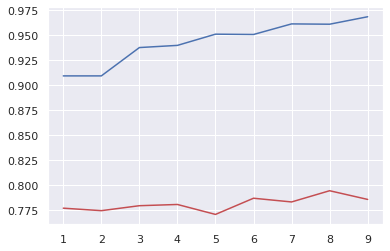

In [8]:
n_estimators_range = np.arange(1,10)
train_scores, test_scores = validation_curve(rnd_forest, strat_train_prep, strat_train_labels, param_name="n_estimators", param_range=n_estimators_range, scoring="accuracy", cv = skfold)
plt.plot(n_estimators_range, np.mean(train_scores, 1), label="train score", c='b')
plt.plot(n_estimators_range, np.mean(test_scores, 1), label="test score", c='r')

In [ ]:
svd_rndforest_pip = Pipeline([
    ("svd", TruncatedSVD()),
    ("rnd_forest", RandomForestClassifier(n_jobs=-1))
])

param_grid = [
    {"svd__n_components" : [4,5], "rnd_forest__random_state" : [42], "rnd_forest__max_features" : [3,4,5],
     "rnd_forest__max_depth" : [3,4,5], "rnd_forest__n_estimators" : [100],
    "rnd_forest__min_samples_split" : [2,3,4], "rnd_forest__min_samples_leaf" : [2,3,4]}
]

# param_grid = [
#     {"random_state" : [42], "max_features" : [4,5,6], "max_depth" : [2,3,4], "n_estimators" : [50,100],
#     "min_samples_split" : [2,3,4], "min_samples_leaf" : [2,3,4]}
# ]

#gridsearch = GridSearchCV(rnd_forest, param_grid = param_grid, cv = skfold, scoring="accuracy", return_train_score=False)
gridsearch = GridSearchCV(svd_rndforest_pip, param_grid = param_grid, cv = skfold, scoring="accuracy", return_train_score=False)
gridsearch.fit(strat_train_prep, strat_train_labels)
best_rnd_forest = gridsearch.best_estimator_

/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/home/linuser/.local/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: E

In [ ]:
best_rnd_forest

In [ ]:
pred_scores = cross_val_predict(best_rnd_forest, strat_train_prep, strat_train_labels, cv = skfold, method="predict_proba")
precisions, recalls, thresholds = precision_recall_curve(strat_train_labels, pred_scores[:, 1])

sns.lineplot(thresholds, precisions[:-1], color="r")
sns.lineplot(thresholds, recalls[:-1], color="b")

In [ ]:
plot_precision_recall_curve(best_rnd_forest, strat_train_prep, strat_train_labels, response_method="predict_proba")

In [ ]:
pred_scores = cross_val_predict(best_rnd_forest, strat_devtest_prep, strat_devtest_labels, cv = skfold, method="predict_proba")
precisions, recalls, thresholds = precision_recall_curve(strat_devtest_labels, pred_scores[:, 1])

sns.lineplot(thresholds, precisions[:-1], color="r")
sns.lineplot(thresholds, recalls[:-1], color="b")

In [ ]:
pred = best_rnd_forest.predict(strat_devtest_prep)
confusion_matrix(strat_devtest_labels, pred)

In [ ]:
rnd_forest.fit(strat_train_prep, strat_train_labels)
pred = rnd_forest.predict(strat_devtest_prep)
confusion_matrix(strat_devtest_labels, pred)

In [ ]:
thresh = 0.65
custom_thresh_preds = pred_scores > thresh
precisions, recalls, thresholds = precision_recall_curve(strat_devtest_labels, custom_thresh_preds[:, 1])

sns.lineplot(thresholds, precisions[:-1], color="r")
sns.lineplot(thresholds, recalls[:-1], color="b")

In [ ]:
confusion_matrix(strat_devtest_labels, custom_thresh_preds[:,1])

In [ ]:
#best_model = RandomForestClassifier(random_state=42)
best_model = best_rnd_forest

full_train = titanic.drop("Survived", axis=1)
full_train_prep = attr_pip.fit_transform(full_train)
best_model.fit(full_train_prep, titanic_labels)

test = pd.read_csv(fname_test)
test_prep = attr_pip.fit_transform(test)
titanic_prep = attr_pip.fit_transform(titanic)

#sgd_clf.fit(titanic_prep, titanic_labels)
#survival_pred = sgd_clf.predict(test_prep)

survival_pred = best_model.predict(test_prep)


# survival_proba = best_model.predict_proba(test_prep)
# survival_pred = survival_proba > thresh
# survival_pred = survival_pred[:, 1].astype(int)


survival_pred = pd.DataFrame(survival_pred, columns=["Survived"])

id_survival = pd.concat([test.PassengerId, survival_pred], axis=1)
id_survival.set_index("PassengerId", inplace=True)
id_survival.to_csv("predicition.csv")
id_survival